In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.stats import gmean

2 3
t0= 2944.406189883313
t0= 2939.8346497354582
t0= 2944.406189883313
t0= 2939.8346497354582
t0= 2944.406189883313
t0= 2939.8346497354582


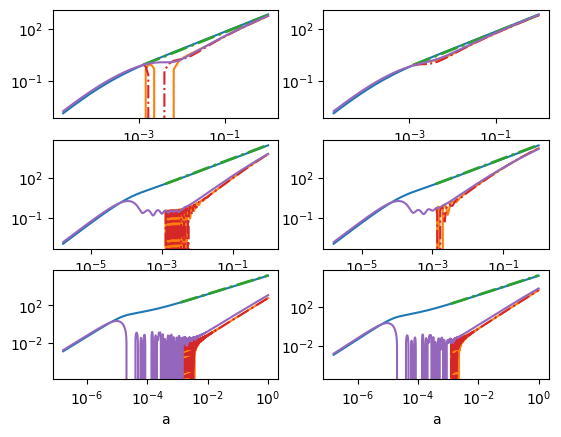

In [30]:
def f1(k_ind=0,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .1,
    a_end = 1,
    z = 800,
    reduce_factor=1
     ):
    Omega_M = 0.98
    Omega_b = 0.01
    factor /= reduce_factor
    
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    #H0 = 21.25
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    pb = pts[k_ind]
    a = pb["a"]
    cdm = pb["delta_cdm"]
    neutrino = pb["delta_ncdm[0]"]
    #plt.figure(k_ind)#np.random.randint(1,1000))
    tau = pb["tau [Mpc]"]
    a_interp = scipy.interpolate.interp1d(tau,a)
    
    a0 = 1/(z+1)
    delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])
    
    
    a_interp = scipy.interpolate.interp1d(a,tau)
    tau_interp = scipy.interpolate.interp1d(tau,a)
    
    
    
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    tau_class =  pts[k_ind]["tau [Mpc]"]
    
    tid = bg['proper time [Gyr]'] * 306.4
    print("t0=",tid[-1])
    
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    theta_neu_interp = scipy.interpolate.interp1d(a_class,theta_neutrino_class)
    delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class) 
    tau_interp = scipy.interpolate.interp1d(a_class,tau_class)
    
    
    delta0 = delta_interp(a0)
    
    def H(a,om=Omega_M,ol=Omega_lambda):
        return H0 * np.sqrt(om / a + ol* a**2)
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb

    def cs(a):
        return factor * T0 / a/ mv

    def func1(a,y,k):
        delta = a * delta0/a0
        delta_nu = y[0]
        d_delta_nu = y[1]
        d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu
        
        
        return [d_delta_nu,d2_delta_nu]
    
    
    o = 0.00001 
    
    diff = (delta_interp(a0+o/2)-delta_interp(a0-o/2))/o
    
    diff_neu =  (delta_interp_neu(a0+o/2)-delta_interp_neu(a0-o/2))/o
    y0 = [delta_interp_neu(a0),diff_neu]# diff]
    
    
    
    a_span = [a0,a_end]
    sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(k,))#,t_eval=np.logspace(np.log10(a0),0,100))
    t_sol = sol.t 
    #plt.figure(np.random.randint(1,100000))
    
    plt.loglog(a_class,-cdm,label="CLASS cdm") 
    delta_neu_sol = sol.y[0]
    
    t0 = tid[-1]
    def neu_eq(a,c1,c2,D0):
        H0 = 2/(3*t0)
        val = 2 *k*  cs(a) * np.sqrt(a)  / H0
        si,ci = special.sici(val)
        return a * D0 + c1 * np.cos(val)- c2 * np.sin(val) + a* val**2 * D0 * (np.cos(val)*ci+np.sin(val)*si)
        
    def f(a,c1,c2):
            #a = np.log10(a)
            res  = a - 2*c1 * np.sqrt(kappa)/ np.sqrt(a)+c2
            return res # np.log10(res)
        
    #print(H0*c,"før")
    H0 = 2/(3*t0) 
    #print(H0*c,"efter")
    A = np.sqrt(delta_interp_neu(a0)**2 + (diff_neu/(-0.5 * 2*k*cs(a0)/(H0*np.sqrt(a0))))**2)
    C1 = A
    C2 = 2*np.pi*delta0/a0 *( k*cs(a0)*a0/H0 )**2
    
    def eq(a,C1,C2):
        H0 = 2/(3*t0)
        M = 2 * k*cs(a)*np.sqrt(a) /H0
        dcdm = delta0/a0
        res = a*dcdm + C1*np.cos(M) - C2*np.sin(M) + M**2*a*dcdm*(np.cos(M)*CosIntegral(M) + np.sin(M)*SinIntegral(M))
        return res
    
    plt.loglog(t_sol,-eq(t_sol,C1,C2),label="Eq1.")
    plt.loglog(t_sol, - t_sol * delta0/a0,"-.",lw=2,label="cdm approx.")
    plt.loglog(t_sol,-delta_neu_sol,"-.",label=r"Num. Neu. $m_{\nu}=$%seV " % (mv_test))
    plt.loglog(a_class,-delta_neutrino_class,label=r"CLASS Neu. $m_{\nu}=$%seV " % (mv_test))
    #plt.ylabel("$-\delta$",rotation=0)
    #plt.legend()
    #plt.title(r"$\delta_{cdm}$ and $\delta_{\nu}$ with k=%s[1/Mpc] with cs-factor=%.2f"%(k,factor)) #using a cs-factor = %.2ffactor
    plt.xlabel("a")
    
    savtyp = "lambdacdm"
    if Omega_M >= 0.93:
        savtyp = "EdS"
    #plt.savefig("num-neutrino-versus-class with k=%s %s %.4f mv=%.1f approx-cdm-source.png"% (kvec[k_ind],savtyp,factor,mv_test))
    plt.savefig("anayltical-neutrinos-with-k=%s-using-cs-factor=%.2f-with-mv=%.1f.png"%(kvec[k_ind],factor,mv_test))
    
    cosmo.struct_cleanup()
    return None



#f1(kvec=[1])
#f1(kvec=[.1])
#for i in [0.254]:#,1,3]:#np.logspace(-3,np.log10(3),10):    f1(kvec=[i])#,a_end=1000)
    #f1(kvec=[i],mv_test=0.4)

mlist = [0.1,0.3]
kvec  = [0.01,.1,1]
i=1
print(len(mlist),len(kvec))
for kind,k in enumerate(kvec):
    for mind,m in enumerate(mlist):
        
        plt.subplot( len(kvec),len(mlist), i)#(kind+1)*(mind+1)  )
        f1(kvec=[k],mv_test=m)
        i+=1
    

t0= 2944.406189883313
68.0 før
67.92541079664217 efter
t0= 2944.406189883313
68.0 før
67.92541079664217 efter
t0= 2944.406189883313
68.0 før
67.92541079664217 efter
t0= 2937.5577811448034
68.0 før
68.0837671632309 efter
t0= 2937.5577811448034
68.0 før
68.0837671632309 efter
t0= 2937.5577811448034
68.0 før
68.0837671632309 efter
t0= 2944.406189883313
68.0 før
67.92541079664217 efter
t0= 2944.406189883313
68.0 før
67.92541079664217 efter
t0= 2944.406189883313
68.0 før
67.92541079664217 efter
t0= 2937.5577811448034
68.0 før
68.0837671632309 efter
t0= 2937.5577811448034
68.0 før
68.0837671632309 efter
t0= 2937.5577811448034
68.0 før
68.0837671632309 efter


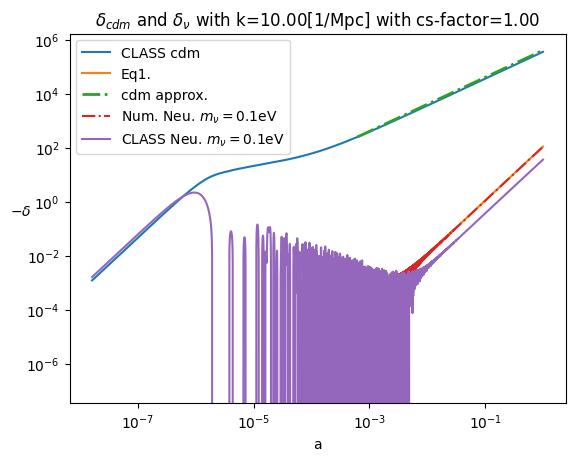

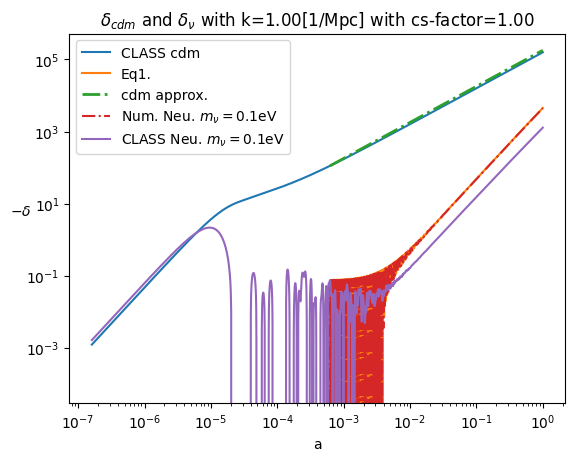

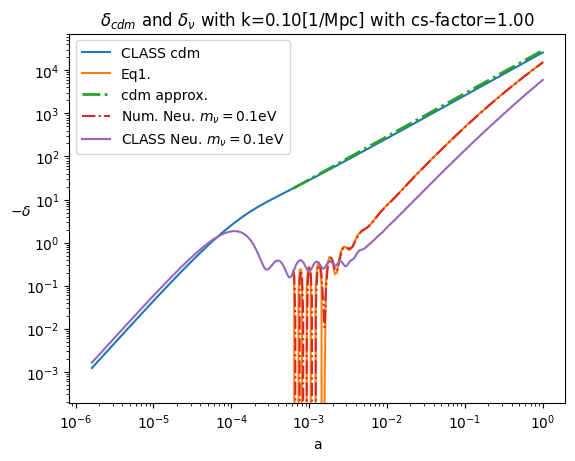

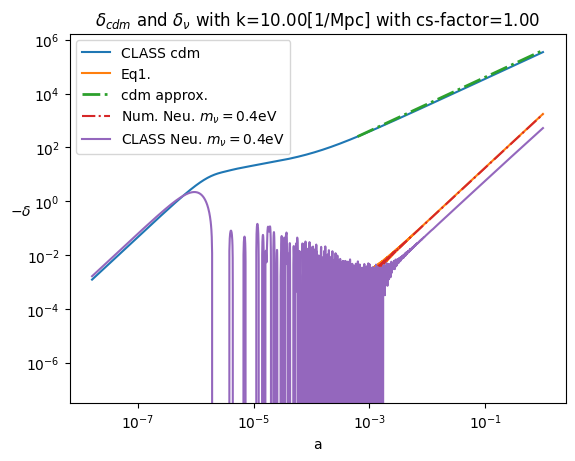

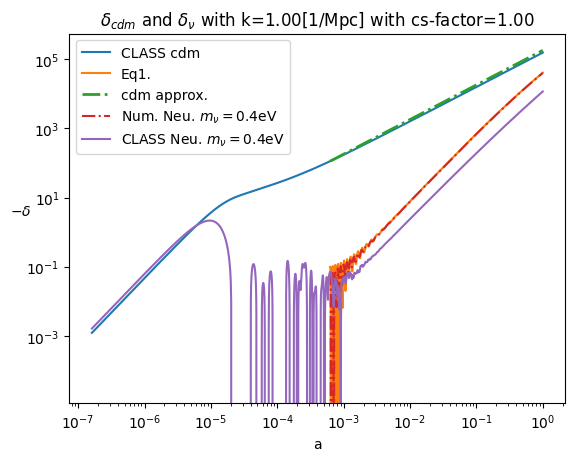

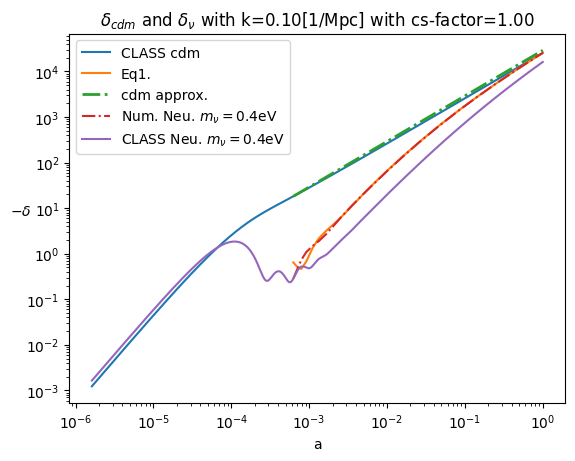

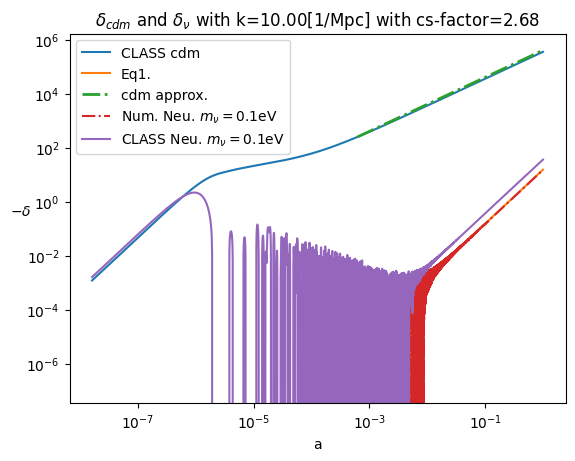

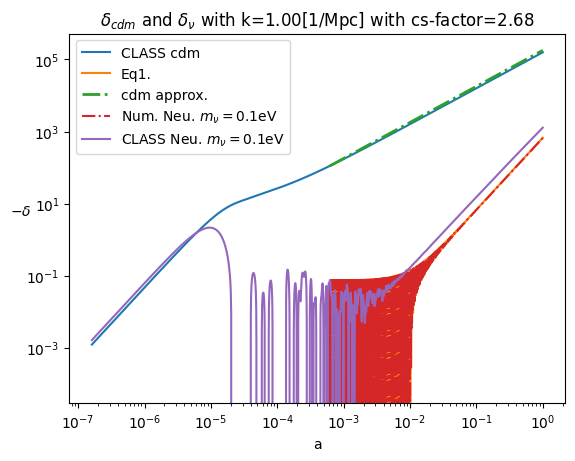

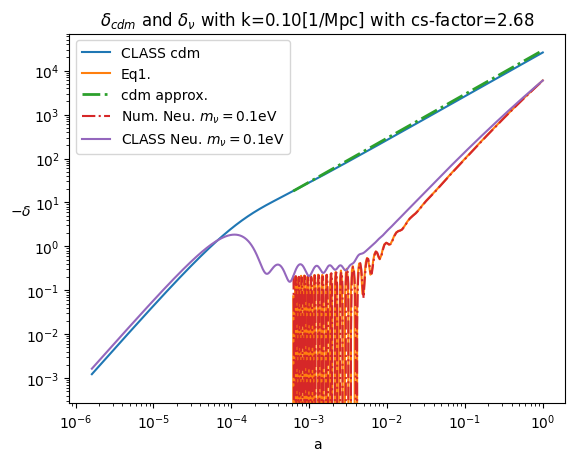

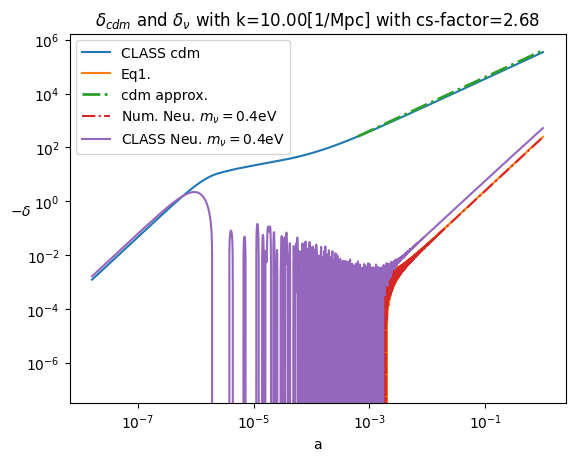

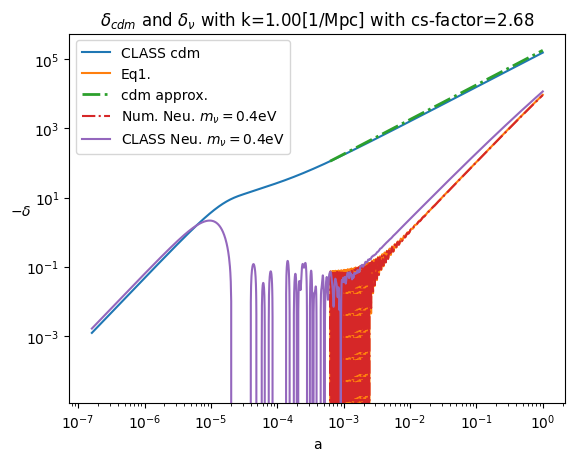

<Figure size 640x480 with 0 Axes>

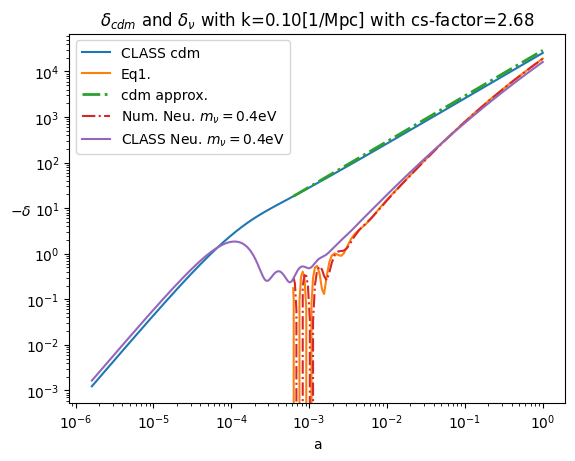

In [11]:

f1(kvec = [10],
   a_end=1e0,
   mv_test = .1,   factor = 1)
f1(kvec = [1],
   a_end=1e0,
   mv_test = .1,   factor = 1)
f1(kvec = [.10],
   a_end=1e0,
   mv_test = .1,   factor = 1)

f1(kvec = [10],
   a_end=1e0,
   mv_test = .4,   factor = 1)
f1(kvec = [1],
   a_end=1e0,
   mv_test = .4,   factor = 1)
f1(kvec = [.10],
   a_end=1e0,
   mv_test = .4,   factor = 1)


f1(kvec = [10],
   a_end=1e0,
   mv_test = .1)
f1(kvec = [1],
   a_end=1e0,
   mv_test = .1)
f1(kvec = [.10],
   a_end=1e0,
   mv_test = .1)

f1(kvec = [10],
   a_end=1e0,
   mv_test = .4)
f1(kvec = [1],
   a_end=1e0,
   mv_test = .4)
f1(kvec = [.10],
   a_end=1e0,
   mv_test = .4)

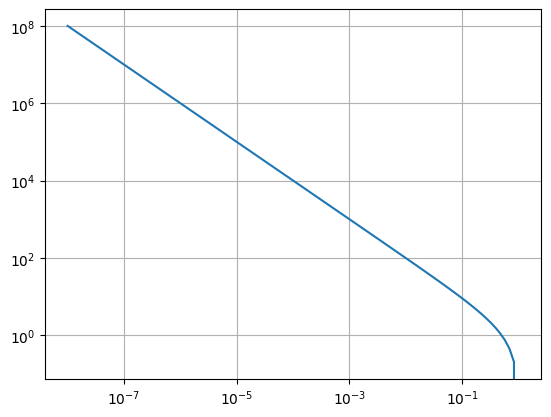

In [4]:
a = np.logspace(-8,0,100)
#a = 1/(1+z)
z = 1/a-1

plt.loglog(a,z)
plt.grid()